In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from pathlib import Path


In [2]:
current_datetime =  datetime.now()
current_date_str = str(current_datetime.date()).replace('-','_')
output_directory = '../data/processed/player_data/'
output_filename = current_date_str + '_clean_player_data.csv'
file_path = output_directory + output_filename

df = pd.read_csv(file_path)

duplicate_players = df[df.duplicated(subset=['Player'], keep=False)]

duplicate_players_same_team = duplicate_players[duplicate_players.duplicated(subset=['Player', 'Team'], keep=False)]

df = df.drop_duplicates(subset=['Player', 'Team'], keep='first')



forward_df = df[(df['Pos'] == 'LW') | (df['Pos'] == 'RW') 
                      | (df['Pos'] == 'C') | (df['Pos'] == 'F') | (df['Pos'] == 'W')]


Lets take a look at our features and drop columns that will be irrelevant to our model

In [3]:
print(forward_df.columns)

Index(['Unnamed: 0', 'Player', 'Age', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-',
       'PIM', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI',
       'ATOI', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Ht',
       'Wt', 'S/C', 'Exp', 'Team', 'specific_pos', 'Cap%', 'Salary'],
      dtype='object')


In [4]:
def prep_atoi(atoi_string):
    list = atoi_string.split(':')
    minutes = int(list[0])
    seconds = int(list[1])

    return minutes + (seconds/60)

In [5]:
columns_to_drop = ['Unnamed: 0', 'Pos', 'EV.1', 'PP.1', 'SH.1', 'TOI',  'S/C','Team', 'specific_pos', 'Cap%', 'ATOI', 'Ht', 'Wt' ]

forward_df['ATOI'] = forward_df['ATOI'].apply(prep_atoi)

df = forward_df.drop(columns=columns_to_drop)
df = df.dropna()

/tmp/ipykernel_8700/3568076167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['ATOI'] = forward_df['ATOI'].apply(prep_atoi)


Next I want to normalize some statistics to per game. 

In [6]:
df.columns

Index(['Player', 'Age', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EV', 'PP', 'SH',
       'GW', 'S', 'S%', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%',
       'Exp', 'Salary'],
      dtype='object')

In [7]:
df['points_per_game'] = (df['G'] + df['A']) / df['GP']
df['penalty_mins_per_game'] = df['PIM'] / df['GP']
df['shots_per_game'] = df['S'] / df['GP']
df['shot%_per_game'] = df['S%'] / df['GP']
df['hits_per_game'] = df['HIT'] / df['GP']
df['blocks_per_game'] = df['BLK'] / df['GP']
df['years_of_experience'] = df['Exp']

 
df = df.drop(columns=['G', 'A', 'PIM', 'S', 'S%', 'HIT', 'BLK', 'GP', 'PTS', 'Exp'])

Feature Importance Ranking:
1. Feature 'points_per_game': 0.3827518254803927
2. Feature 'shots_per_game': 0.19712989009539533
3. Feature 'years_of_experience': 0.12361007275341959
4. Feature '+/-': 0.03714859375326675
5. Feature 'Age': 0.033354163200381946
6. Feature 'shot%_per_game': 0.02622773963463928
7. Feature 'blocks_per_game': 0.023322401872210817
8. Feature 'hits_per_game': 0.021693962985118758
9. Feature 'FOL': 0.020495259730688522
10. Feature 'FO%': 0.020223325443260415
11. Feature 'FOW': 0.018384809127267792
12. Feature 'OPS': 0.016467657548955673
13. Feature 'PP': 0.0161280901707896
14. Feature 'PS': 0.016079812459563348
15. Feature 'penalty_mins_per_game': 0.014645494830556584
16. Feature 'EV': 0.013619969002977862
17. Feature 'DPS': 0.011108591081050853
18. Feature 'SH': 0.0038337610329668382
19. Feature 'GW': 0.003774579797097421


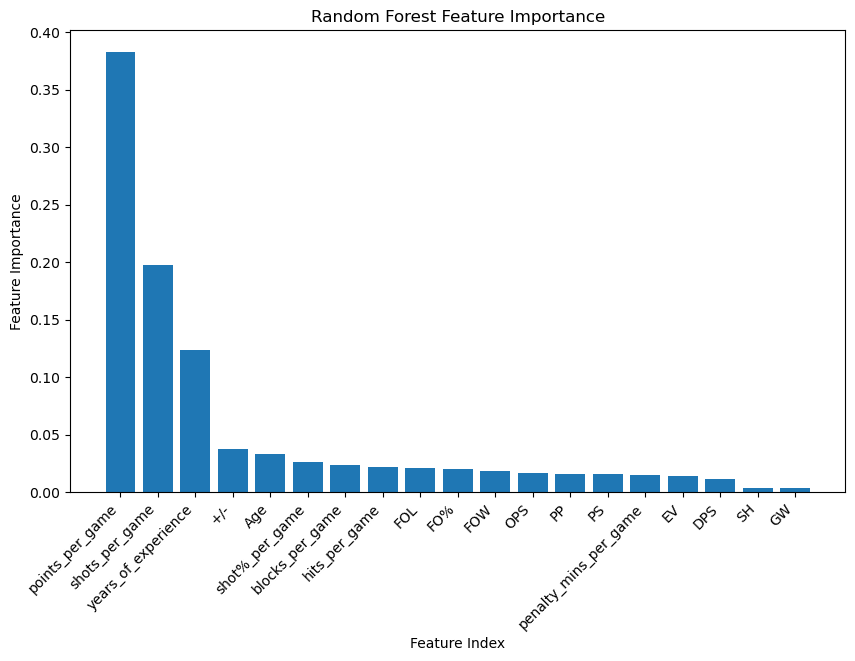

In [8]:
player_names = df['Player']


# Features (X) - Exclude the target column
X = df.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = df['Salary']


X_encoded = pd.get_dummies(X)


# Split the data into training and testing sets
# Adjust the test_size parameter as needed
X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model to your training data
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]



# Print feature importance ranking with original column names
print("Feature Importance Ranking:")

ordered_feature_importance = []

for i, index in enumerate(sorted_indices):
    original_column_name = X_encoded.columns[index]
    ordered_feature_importance.append(original_column_name)
    print(f"{i + 1}. Feature '{original_column_name}': {feature_importances[index]}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), ordered_feature_importance)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [9]:
print(ordered_feature_importance[:7])

['points_per_game', 'shots_per_game', 'years_of_experience', '+/-', 'Age', 'shot%_per_game', 'blocks_per_game']


In [10]:
important_features = ['Player','Salary'] + ordered_feature_importance[:7] 


final_dataset = df[important_features]

Mean Squared Error: 2622025596103.5005
R-squared: 0.6801106884030026


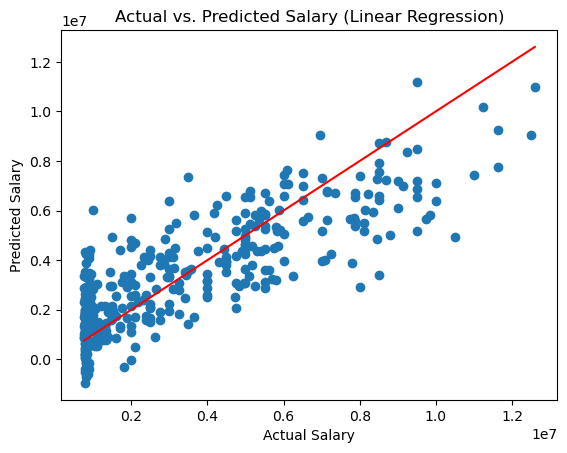

In [11]:
player_names = final_dataset['Player']

X = final_dataset.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = final_dataset['Salary']

X_encoded = pd.get_dummies(X)


X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)


linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

predictions_linear = linear_model.predict(X)


results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_linear})




# Evaluate the model
mse = mean_squared_error(y, predictions_linear)
r2 = r2_score(y, predictions_linear)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting actual vs. predicted values
plt.scatter(y, predictions_linear)

plotting_values = np.linspace(np.min(y), np.max(y), 1000)
plt.plot(plotting_values, plotting_values, color='r')
plt.plot()
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary (Linear Regression)")
plt.show()


Random Forest Model:
Mean Squared Error: 901672775873.7018
R-squared: 0.8899951686251172


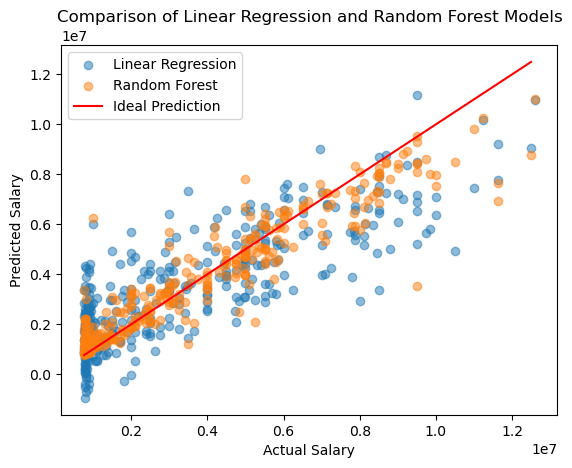

In [12]:
# Random Forest Model
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)
predictions_rf = random_forest_model.predict(X_encoded)

# Evaluate Random Forest model
mse_rf = mean_squared_error(y, predictions_rf)
r2_rf = r2_score(y, predictions_rf)

print("\nRandom Forest Model:")
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)

# Compare the models visually
plt.scatter(y, predictions_linear, label='Linear Regression', alpha=0.5)
plt.scatter(y, predictions_rf, label='Random Forest', alpha=0.5)

plt.plot(np.linspace(np.min(y_test), np.max(y_test), 100), np.linspace(np.min(y_test), np.max(y_test), 100), color='r', label='Ideal Prediction')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Comparison of Linear Regression and Random Forest Models")
plt.legend()
plt.show()

In [13]:
results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_rf})
results_df['difference'] = results_df['Actual_Salary'] - results_df['Predicted_Salary']
results_df['Actual_Salary'] = results_df['Actual_Salary'].apply(lambda x: "{:e}".format(x))
results_df['Predicted_Salary'] = results_df['Predicted_Salary'].apply(lambda x: "{:e}".format(x))



overpaid_df = results_df[results_df['difference'] > 0]
underpaid_df = results_df[results_df['difference'] < 0]


In [14]:
print(f'There are {results_df.shape[0]} forwards in the dataset and {overpaid_df.shape[0]} are overpaid, and {underpaid_df.shape[0]} are underpaid')

There are 371 forwards in the dataset and 141 are overpaid, and 230 are underpaid


In [15]:
overpaid_df.sort_values(by='difference', ascending=False).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
391,Jamie Benn,9.500000e+06,3.530038e+06,5969961.91
216,Auston Matthews,1.164025e+07,6.922901e+06,4717348.67
0,Artemi Panarin,1.164286e+07,7.656867e+06,3985989.81
571,Connor McDavid,1.250000e+07,8.779353e+06,3720647.49
635,Jakob Silfverberg,5.250000e+06,2.103750e+06,3146250.00
196,Aleksander Barkov,1.000000e+07,7.533560e+06,2466440.50
53,Jesperi Kotkaniemi,4.820000e+06,2.502712e+06,2317288.13
622,Brandon Tanev,3.500000e+06,1.195500e+06,2304500.00
665,Logan Couture,8.000000e+06,5.757750e+06,2242250.00
647,Tomas Hertl,8.137500e+06,6.034250e+06,2103249.99


In [16]:
underpaid_df.sort_values(by='difference', ascending=True).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
175,James van Riemsdyk,1.000000e+06,6.270242e+06,-5270241.67
533,Jonathan Marchessault,5.000000e+06,7.819607e+06,-2819607.13
44,Martin Necas,3.000000e+06,5.703821e+06,-2703821.41
539,Michael Amadio,7.625000e+05,3.372339e+06,-2609839.29
7,Blake Wheeler,8.000000e+05,3.007660e+06,-2207659.52
384,Matt Duchene,3.000000e+06,5.111500e+06,-2111500.00
554,Trevor Moore,4.200000e+06,5.908423e+06,-1708422.60
112,Kyle Palmieri,5.000000e+06,6.689833e+06,-1689833.34
262,Brandon Hagel,1.500000e+06,3.095192e+06,-1595191.67
658,Justin Bailey,7.750000e+05,2.210875e+06,-1435874.58


In [17]:

players_teams_df = forward_df[['Player', 'Team']]

output_df = results_df.merge(players_teams_df, on='Player', how='inner')


current_directory = Path.cwd()

data_directory = current_directory.parent / 'data'

output_directory = data_directory / 'model_outputs'

output_directory.mkdir(parents=True, exist_ok=True)


file_name = current_date_str + '_forward_predictions.csv'

output_file_path = output_directory / file_name


output_df.to_csv(output_file_path)


In [18]:
# import plotly
import dash